In [1]:
import sys
sys.path.insert(0, "..")

In [2]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import networkx as nx
import cobra
from molmass import Formula
from cobra.io import read_sbml_model
from experiments.fast_dFBA import setup_drawdown, MichaelisMentenBounds, dFBA
from utils.cobra_utils import get_or_create_exchange
from utils.utils import pp
from parameters.drawdown import *
from plotting.diagnostic import uptakes_and_secretions, plot_pathway, plot_metabolite_fluxes

In [3]:
MODEL_FILE = "../model/Rpom_05.xml"
BIOMASS_ID = "RPOM_provisional_biomass"
DATA_FILE = "../data/clean/CUE/cue_data.csv"

# Load data
data = pd.read_csv(DATA_FILE)

# Load and set up model
model = read_sbml_model(MODEL_FILE)
setup_drawdown(model)

# Set up Michaelis-Menten medium
ex_glc = model.reactions.get_by_id("EX_glc")
ex_ace = get_or_create_exchange(model, "ACET[e]")

# Get V_maxes
V_max_glc = 10 * abs(float(ex_glc._annotation["Experimental rate"]))
V_max_ace = 10 * abs(float(ex_ace._annotation["Experimental rate"]))

dynamic_medium = {
    ex_glc: MichaelisMentenBounds("Glucose[e]", V_max_glc, K_M.to("mM").magnitude),
    ex_ace: MichaelisMentenBounds(
        "ACET[e]", V_max_ace, K_M.to("mM").magnitude)
}

# Initial state
initial_conditions = data[["Initial_mM_Glucose",
                            "Initial_mM_Acetate"]].drop_duplicates().values

Scaling...
 A: min|aij| =  1.000e+00  max|aij| =  1.000e+00  ratio =  1.000e+00
Problem data seem to be well scaled


In [4]:
initial_glucose, initial_acetate = initial_conditions[3, :]

initial_biomass = (data[(data["Type"] == "counts") &
                        (data["Time (h)"] == 0) &
                        (data["Initial_mM_Glucose"] == initial_glucose) &
                        (data["Initial_mM_Acetate"] == initial_acetate)
                        ]["Value"].mean() * (1/u.mL) * MASS_PER_CELL).to("g/L").magnitude
tmax = (data[(data["Type"] == "counts") & (data["Initial_mM_Glucose"] == initial_glucose) & (
    data["Initial_mM_Acetate"] == initial_acetate)]["Time (h)"].max())

substrates = {
    "Glucose[e]" : initial_glucose,
    "ACET[e]": initial_acetate
}

with model:
    for exchange, bounds in dynamic_medium.items():
        bounds.bound(exchange, substrates[bounds.substrate_id])

    # Using lexicographic optimization,
    # first optimize for biomass, then for the exchange fluxes
    # (holding optimal biomass as a constraint),
    # thus guaranteeing a unique optimal set of exchange fluxes.
    lex_constraints = cobra.util.add_lexicographic_constraints(
        model, [BIOMASS_ID, "EX_glc", ex_ace.id], ['max', "max", "max"])
    fluxes = lex_constraints.values

fluxes *= initial_biomass
fluxes

array([ 0.00069602, -0.00720359,  0.        ])

(<Figure size 640x480 with 1 Axes>,
 <AxesSubplot:title={'center':'2.0 mM Glucose, 0.0 mM Acetate'}, ylabel='flux (mg / hr)'>)

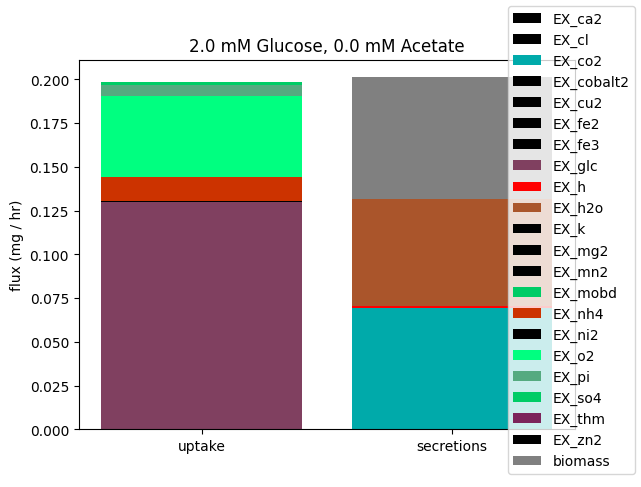

In [5]:
with model:
    for exchange, bounds in dynamic_medium.items():
        bounds.bound(exchange, substrates[bounds.substrate_id])
    sol = model.optimize()

boundary_ids = [rxn.id for rxn in model.boundary]
boundary_fluxes = sol.fluxes[boundary_ids].reset_index()
boundary_fluxes["fluxes"] = boundary_fluxes["fluxes"] * initial_biomass * CUE_VOLUME.to("L").magnitude  # convert to mmol/hr
boundary_fluxes["Secreting"] = ((np.array([bool(rxn.reactants) for rxn in model.boundary]) & (boundary_fluxes["fluxes"] > 0))
                                | (np.array([bool(rxn.products) for rxn in model.boundary]) & (boundary_fluxes["fluxes"] < 0)))
boundary_fluxes["Mol mass"] = [Formula(list(rxn.metabolites.keys())[0].formula).mass for rxn in model.boundary]

uptakes_and_secretions(model, boundary_fluxes, sol, initial_biomass, CUE_VOLUME, initial_glucose, initial_acetate)

In [6]:
from cobra.flux_analysis.reaction import assess
with model:
    for exchange, bounds in dynamic_medium.items():
        bounds.bound(exchange, substrates[bounds.substrate_id])
    
    assessment = assess(model, "RPOM_provisional_biomass")
    if assessment != True:
        print(pp(assessment))
    else:
        print("Passed")

Passed


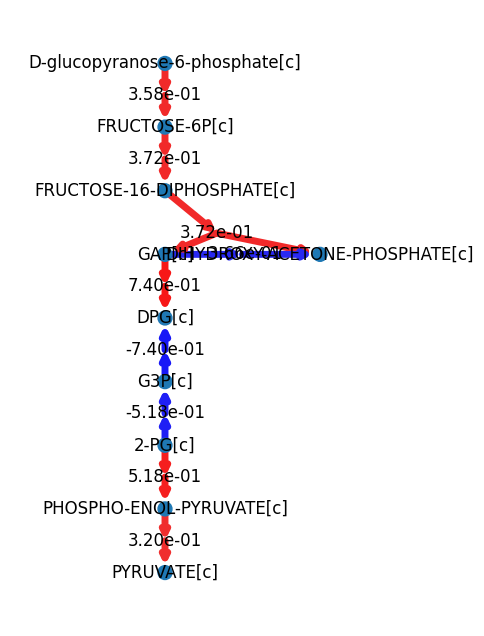

In [7]:
glycolysis = nx.DiGraph()

# Metabolites
glycolysis.add_nodes_from([
    ("D-glucopyranose-6-phosphate[c]", {"pos": (0, 0)}),
    ("FRUCTOSE-6P[c]", {"pos": (0, -10)}),
    ("FRUCTOSE-16-DIPHOSPHATE[c]", {"pos": (0, -20)}),
    ("GAP[c]", {"pos": (0, -30)}),
    ("DIHYDROXY-ACETONE-PHOSPHATE[c]", {"pos": (10, -30)}),
    ("DPG[c]", {"pos": (0, -40)}),
    ("G3P[c]", {"pos": (0, -50)}),
    ("2-PG[c]", {"pos": (0, -60)}),
    ("PHOSPHO-ENOL-PYRUVATE[c]", {"pos": (0, -70)}),
    ("PYRUVATE[c]", {"pos": (0, -80)}),
])

# Reactions
glyc_reactions = ["PGLUCISOM-RXN",
                  "6PFRUCTPHOS-RXN",
                  "F16ALDOLASE-RXN",
                  "TRIOSEPISOMERIZATION-RXN",
                  "GAPOXNPHOSPHN-RXN",
                  "PHOSGLYPHOS-RXN",
                  "3PGAREARR-RXN",
                  "2PGADEHYDRAT-RXN",
                  "PEPDEPHOS-RXN"]

fig, ax = plt.subplots()
plot_pathway(model, glycolysis, glyc_reactions, ax)
ax.set_xlim([-10, 20])
fig.set_size_inches(6,8)

In [8]:
sp = sol.shadow_prices.reset_index()
sp["abs(shadow_price)"] = sp["shadow_prices"].abs()
sp = sp.sort_values("abs(shadow_price)", ascending=False)

lines=100
for i, (_, row) in enumerate(sp.iterrows()):
    if i > lines:
        break
    print(f"{row['index'].ljust(40)}\t{str(row['shadow_prices']).rjust(20)}")

KDO2-LIPID-A[c]                         	 -2.1785771023943448
C6[c]                                   	 -2.0313448589373757
KDO2-LIPID-IVA-COLD[c]                  	 -2.0198423399178824
C5[c]                                   	 -1.8921643787949702
KDO2-LAUROYL-LIPID-IVA[c]               	 -1.8427035470093664
KDO2-PALMITOLEOYL-LIPID-IVA[c]          	  -1.683968784532904
KDO2-LIPID-IVA[c]                       	 -1.5574410753125356
KDO2-LIPID-IVA[p]                       	 -1.5574410753125356
KDO-LIPID-IVA[c]                        	 -1.5528400677045224
LIPID-IV-A[c]                           	  -1.548239060096509
BISOHMYR-GLC[c]                         	 -1.5436380524884956
CPD0-2283[p]                            	 -1.4263123584841573
CPD0-2278[p]                            	 -1.3791520305020197
CPD-9646[c]                             	  -1.320489183499304
UNDECAPRENYL-DIPHOSPHATE[c]             	 -1.3193389315973005
CPD-7695[c]                             	 -1.3101369163812737
C4[c]   

In [9]:
sp[sp["shadow_prices"] > 0].sort_values("abs(shadow_price)")

,index,shadow_prices,abs(shadow_price)
353,PROTON[p],4.510281e-17,4.510281e-17
245,CPD-3[c],2.910383e-11,2.910383e-11
246,CPD-3[p],2.910383e-11,2.910383e-11
615,GLUTAMATE-1-SEMIALDEHYDE[c],5.751260e-04,5.751260e-04
223,5-AMINO-LEVULINATE[c],5.751260e-04,5.751260e-04
...,...,...,...
1349,R-3-hydroxy-cis-vaccenoyl-ACPs[c],5.820275e-01,5.820275e-01
1348,3-oxo-cis-vaccenoyl-ACPs[c],5.889290e-01,5.889290e-01
1157,CPD-18353[c],8.350829e-01,8.350829e-01
1593,CPD-12258[p],1.169806e+00,1.169806e+00


(-50.0, 20.0)

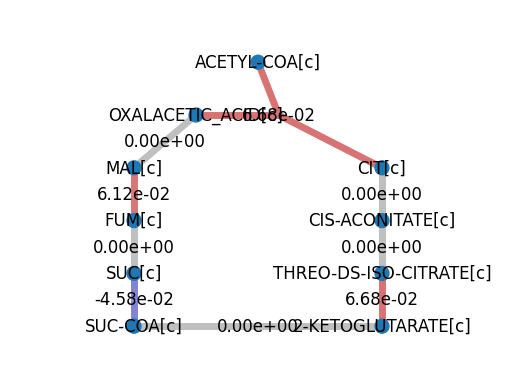

In [10]:
tca = nx.Graph()

# Metabolites
tca.add_nodes_from([
    ("ACETYL-COA[c]", {"pos": (0, 10)}),
    ("CIT[c]", {"pos": (10, -10)}),
    ("CIS-ACONITATE[c]", {"pos": (10, -20)}),
    ("THREO-DS-ISO-CITRATE[c]", {"pos": (10, -30)}),
    ("2-KETOGLUTARATE[c]", {"pos": (10, -40)}),
    ("SUC-COA[c]", {"pos": (-10, -40)}),
    ("SUC[c]", {"pos": (-10, -30)}),
    ("FUM[c]", {"pos": (-10, -20)}),
    ("MAL[c]", {"pos": (-10, -10)}),
    ("OXALACETIC_ACID[c]", {"pos": (-5, 0)}),
])

# Reactions
tca_reactions = ["CITSYN-RXN",
                  "ACONITATEDEHYDR-RXN",
                  "ACONITATEHYDR-RXN",
                  "ISOCITDEH-RXN",
                  "2OXOGLUTARATEDEH-RXN",
                  "SUCCCOASYN-RXN",
                  "RXN-14970-SUC/UBIQUINONE-8//FUM/CPD-9956.31.",
                  "FUMHYDR-RXN",
                  "MALATE-DEH-RXN"]

fig, ax = plt.subplots()
plot_pathway(model, tca, tca_reactions, ax)
ax.set_xlim([-20, 20])
ax.set_ylim([-50, 20])

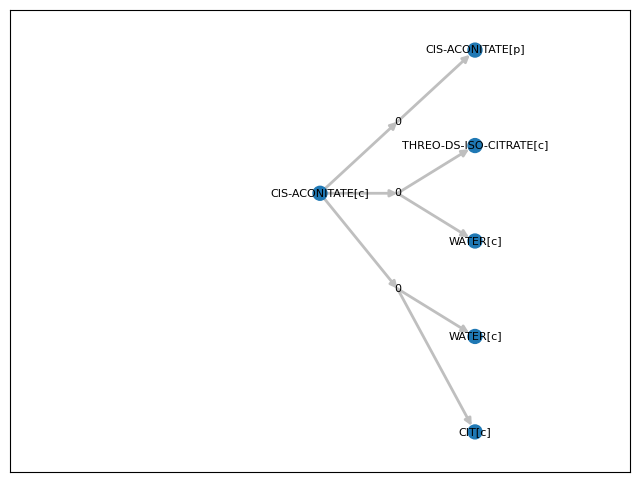

In [11]:
fig, ax = plt.subplots()
g, _ = plot_metabolite_fluxes(model, "CIS-ACONITATE[c]", ax=ax)
ax.set_xlim(-40, 40)
fig.set_size_inches(8, 6)

In [12]:
sol.shadow_prices[sol.shadow_prices < 0].sort_values(ascending=True)

KDO2-LIPID-A[c]                               -2.178577e+00
C6[c]                                         -2.031345e+00
KDO2-LIPID-IVA-COLD[c]                        -2.019842e+00
C5[c]                                         -1.892164e+00
KDO2-LAUROYL-LIPID-IVA[c]                     -1.842704e+00
                                                   ...     
2-HEXAPRENYL-3-METHYL-5-HYDROXY-6-METHOX[c]   -4.313445e-04
CPD-9873[c]                                   -4.313445e-04
CPD-7158[c]                                   -4.313445e-04
CO+2[c]                                       -8.731149e-13
THIAMINE[p]                                   -7.882583e-14
Name: shadow_prices, Length: 1085, dtype: float64

(<networkx.classes.digraph.DiGraph at 0x7f04ae2c2ad0>, <AxesSubplot:>)

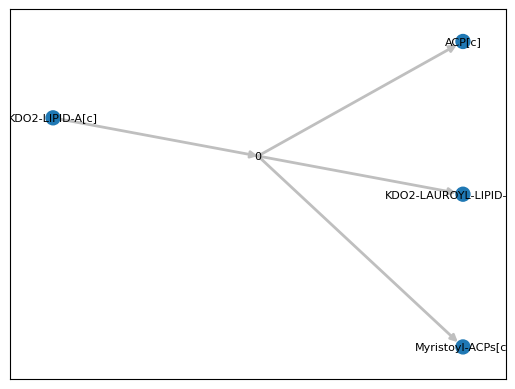

In [13]:
plot_metabolite_fluxes(model, "KDO2-LIPID-A[c]")

(-20.0, 20.0)

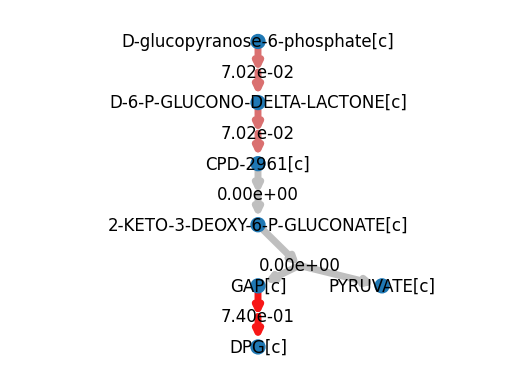

In [14]:
ed = nx.DiGraph()

# Metabolites
ed.add_nodes_from([
    ("D-glucopyranose-6-phosphate[c]", {"pos": (0, 0)}),
    ("D-6-P-GLUCONO-DELTA-LACTONE[c]", {"pos": (0, -10)}),
    ("CPD-2961[c]", {"pos": (0, -20)}),
    ("2-KETO-3-DEOXY-6-P-GLUCONATE[c]", {"pos": (0, -30)}),
    ("GAP[c]", {"pos": (0, -40)}),
    ("PYRUVATE[c]", {"pos": (10, -40)}),
    ("DPG[c]", {"pos": (0, -50)})
])

# Reactions
ed_reactions = ["GLU6PDEHYDROG-RXN",
                  "6PGLUCONOLACT-RXN",
                  "PGLUCONDEHYDRAT-RXN",
                  "KDPGALDOL-RXN",
                  "GAPOXNPHOSPHN-RXN",
                  ]

fig, ax = plt.subplots()
plot_pathway(model, ed, ed_reactions, ax)
ax.set_xlim([-20, 20])

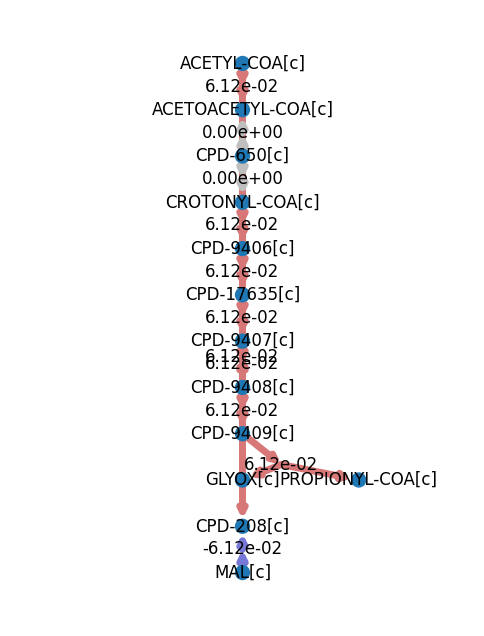

In [15]:
emcoa = nx.DiGraph()

# Metabolites
emcoa.add_nodes_from([
    ("ACETYL-COA[c]", {"pos": (0, 0)}),
    # ("CO-A[c]", {"pos": (10, -10)}),
    ("ACETOACETYL-COA[c]", {"pos": (0, -10)}),
    ("CPD-650[c]", {"pos": (0, -20)}),
    ("CROTONYL-COA[c]", {"pos": (0, -30)}),
    ("CPD-9406[c]", {"pos": (0, -40)}),
    ("CPD-17635[c]", {"pos": (0, -50)}),
    ("CPD-9407[c]", {"pos": (0, -60)}),
    ("CPD-9408[c]", {"pos": (0, -70)}),
    ("CPD-9409[c]", {"pos": (0, -80)}),
    ("PROPIONYL-COA[c]", {"pos": (10, -90)}),
    ("GLYOX[c]", {"pos": (0, -90)}),
    ("CPD-208[c]", {"pos": (0, -100)}),
    ("MAL[c]", {"pos": (0, -110)})
])

# Reactions
emcoa_reactions = ["ACETYL-COA-ACETYLTRANSFER-RXN",
                  "RXN-5901",
                  "3-HYDROXBUTYRYL-COA-DEHYDRATASE-RXN",
                  "RXN-8957",
                  "RXN-16391",
                  "RXN-8958",
                  "RXN-8959",
                  "RXN-8960",
                  "RXN-8961",
                  "MALYL-COA-LYASE-RXN",
                  "MALATE--COA-LIGASE-RXN"
                  ]

fig, ax = plt.subplots()
plot_pathway(model, emcoa, emcoa_reactions, ax)
ax.set_xlim([-20, 20])
fig.set_size_inches(6,8)

(-20.0, 20.0)

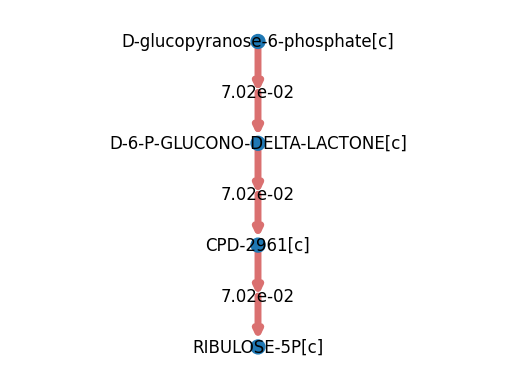

In [16]:
penp = nx.DiGraph()

# Metabolites
penp.add_nodes_from([
    ("D-glucopyranose-6-phosphate[c]", {"pos": (0, 0)}),
    ("D-6-P-GLUCONO-DELTA-LACTONE[c]", {"pos": (0, -10)}),
    ("CPD-2961[c]", {"pos": (0, -20)}),
    ("RIBULOSE-5P[c]", {"pos": (0, -30)})
])

# Reactions
penp_reactions = ["GLU6PDEHYDROG-RXN",
                  "6PGLUCONOLACT-RXN",
                  "RXN-9952"]

fig, ax = plt.subplots()
plot_pathway(model, penp, penp_reactions, ax)
ax.set_xlim([-20, 20])

  0%|          | 0/1688 [00:00<?, ?it/s]

  1%|          | 18/1688 [00:00<00:35, 47.52it/s]

PROTON[c] : 0.06178273480044994 / 0.04140992244120908 = 1.4919790030557232


 12%|█▏        | 201/1688 [00:04<00:27, 54.03it/s]

CU+2[c] : 0.06178273480045047 / 0.04140992244120908 = 1.491979003055736


 22%|██▏       | 377/1688 [00:07<00:25, 52.27it/s]

CA+2[c] : 0.06178273480045037 / 0.04140992244120908 = 1.4919790030557336
FE+3[c] : 0.061782734800450524 / 0.04140992244120908 = 1.4919790030557374


 86%|████████▌ | 1453/1688 [00:33<00:04, 47.45it/s]

NA+[c] : 0.06178273480045057 / 0.04140992244120908 = 1.4919790030557385


 92%|█████████▏| 1548/1688 [00:34<00:02, 58.77it/s]

NI+2[c] : 0.06178273480045018 / 0.04140992244120908 = 1.491979003055729


100%|██████████| 1688/1688 [00:37<00:00, 44.71it/s]


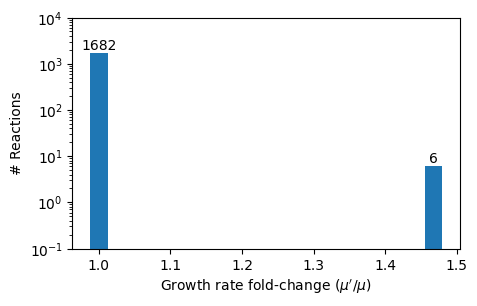

In [17]:
from tqdm import tqdm

baseline = sol.objective_value

fc = np.ones((len(model.metabolites),))
for i, metabolite in enumerate(tqdm(model.metabolites)):
    with model:
        for exchange, bounds in dynamic_medium.items():
            bounds.bound(exchange, substrates[bounds.substrate_id])

        sink = model.add_boundary(metabolite, type="sink")
        sink.bounds = (0,1000)

        mu = model.optimize().objective_value
        fc[i] = mu / baseline
        if abs(fc[i]) > 1.1:
            print(f"{metabolite} : {mu} / {baseline} = {fc[i]}")

fig, ax = plt.subplots()

counts, edges = np.histogram(fc, bins=20)
dx = edges[1] - edges[0]
for count, edge in zip(counts, edges):
    if count == 0:
        continue
    ax.text(edge, 1.2 * count, str(count), horizontalalignment="center")

ax.stairs(counts, edges - dx/2, fill=True)
ax.set_yscale("log")
ax.set_ylabel("# Reactions")
ax.set_xlabel(r"Growth rate fold-change ($\mu'/\mu$)")
ax.set_ylim([0.1, 10000])
fig.set_size_inches(5, 3)

100%|██████████| 1688/1688 [01:13<00:00, 23.01it/s]


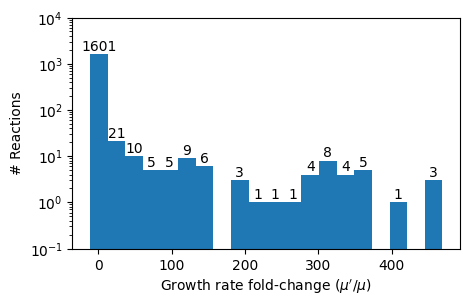

In [18]:
from tqdm import tqdm

baseline = sol.objective_value

fc = np.ones((len(model.metabolites),))
for i, metabolite in enumerate(tqdm(model.metabolites)):
    with model:
        for exchange, bounds in dynamic_medium.items():
            bounds.bound(exchange, substrates[bounds.substrate_id])

        sink = model.add_boundary(metabolite, type="sink")
        sink.bounds = (-1000,0)

        mu = model.optimize().objective_value
        fc[i] = mu / baseline

fig, ax = plt.subplots()

counts, edges = np.histogram(fc, bins=20)
dx = edges[1] - edges[0]
for count, edge in zip(counts, edges):
    if count == 0:
        continue
    ax.text(edge, 1.2 * count, str(count), horizontalalignment="center")

ax.stairs(counts, edges - dx/2, fill=True)
ax.set_yscale("log")
ax.set_ylabel("# Reactions")
ax.set_xlabel(r"Growth rate fold-change ($\mu'/\mu$)")
ax.set_ylim([0.1, 10000])
fig.set_size_inches(5, 3)

In [19]:
diffs = abs(fc - 1)
significant = np.where(diffs > 0.1)[0]

sig = pd.DataFrame({"metabolite" : [model.metabolites[i] for i in significant],
              "fc" : [fc[i] for i in significant]}).sort_values(by="fc", ascending=False)

In [20]:
glycolysis_mets = []
for n in glycolysis.nodes:
    try:
        met = model.metabolites.get_by_id(n)
        glycolysis_mets.append(met.id)
    except:
        continue

sig[[m.id not in glycolysis_mets for m in sig["metabolite"]]][:20]

,metabolite,fc
233,3-P-HYDROXYPYRUVATE[c],426.102421
113,RIBOSE-1P[c],365.150354
166,RIBULOSE-5P[c],365.150354
22,CPD-16551[c],365.150354
20,CPD-15318[c],365.150354
21,CPD-15895[c],365.150354
80,CPD-2961[c],345.570557
27,GLUCOSAMINE-1P[c],322.791676
76,D-GLUCOSAMINE-6-P[c],322.791676
237,GLC-1-P[c],322.791676


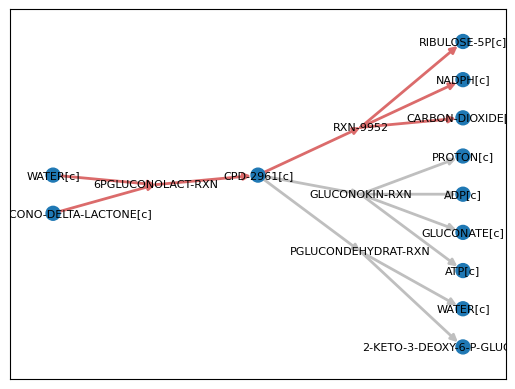

In [36]:
g, _ = plot_metabolite_fluxes(model, "CPD-2961[c]", label_reactions="name")

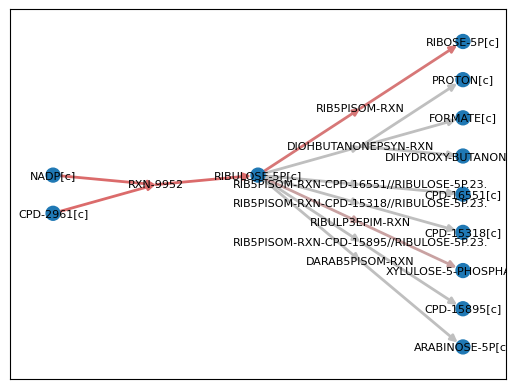

In [37]:
g, _ = plot_metabolite_fluxes(model, "RIBULOSE-5P[c]", label_reactions="name")

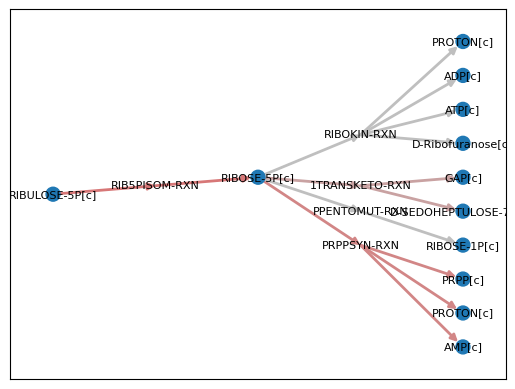

In [38]:
g, _ = plot_metabolite_fluxes(model, "RIBOSE-5P[c]", label_reactions="name")

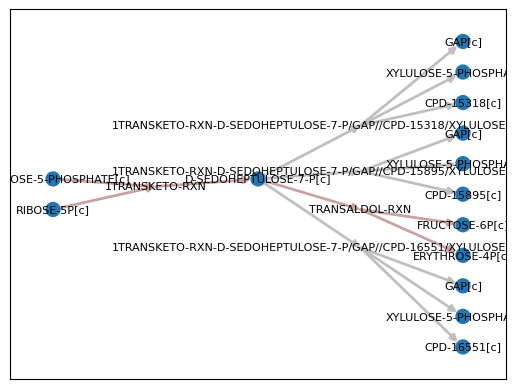

In [43]:
g, _ = plot_metabolite_fluxes(model, "D-SEDOHEPTULOSE-7-P[c]", label_reactions="name")

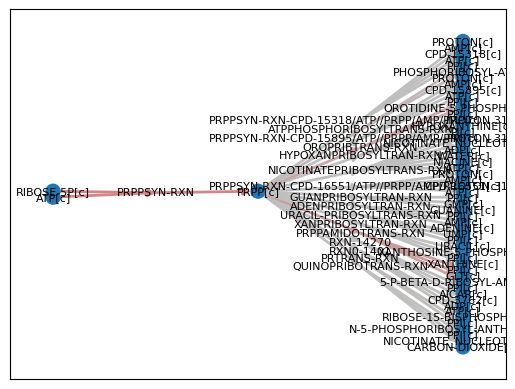

In [40]:
g, _ = plot_metabolite_fluxes(model, "PRPP[c]", label_reactions="name")

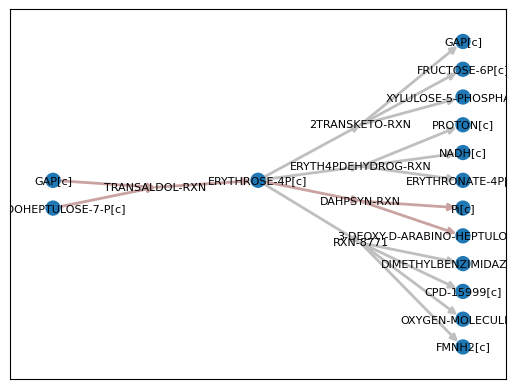

In [45]:
g, _ = plot_metabolite_fluxes(model, "ERYTHROSE-4P[c]", label_reactions="name")

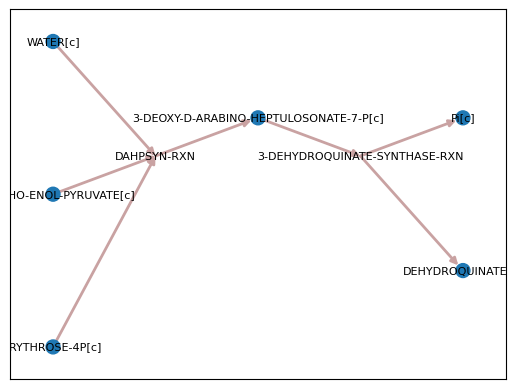

In [48]:
g, _ = plot_metabolite_fluxes(model, "3-DEOXY-D-ARABINO-HEPTULOSONATE-7-P[c]", label_reactions="name")

In [47]:
model.reactions.get_by_id("DAHPSYN-RXN")

Reaction identifier,DAHPSYN-RXN
Name,DAHPSYN-RXN
Memory address,0x7f04b2c17bb0
Stoichiometry,ERYTHROSE-4P[c] + PHOSPHO-ENOL-PYRUVATE[c] + WATER[c] --> 3-DEOXY-D-ARABINO-HEPTULOSONATE-7-P[c] + Pi[c] D-erythrose 4-phosphate + phosphoenolpyruvate + H2O --> 3-deoxy-D-arabino-heptulosonate 7-phosphate + phosphate
GPR,G1G48-1980
Lower bound,0.0
Upper bound,1000.0


In [ ]:
g, _ = plot_metabolite_fluxes(model, "RIBOSE-5P[c]", label_reactions="name")

In [35]:
for rxn in [rxn for rxn in model.reactions if "RXN-15346" in rxn.id]:
    print(f"{rxn.id}\n\t{rxn.reaction}")

RXN-15346
	CPD-16551[c] --> CPD-15895[c]


In [29]:
for rxn in [rxn for rxn in model.reactions if "PPENTOMUT-RXN" in rxn.id]:
    print(f"{rxn.id}\n\t{rxn.reaction}")

D-PPENTOMUT-RXN
	DEOXY-D-RIBOSE-1-PHOSPHATE[c] --> DEOXY-RIBOSE-5P[c]
PPENTOMUT-RXN
	RIBOSE-1P[c] --> RIBOSE-5P[c]
PPENTOMUT-RXN-RIBOSE-1P//CPD-15318.21.
	RIBOSE-1P[c] <=> CPD-15318[c]
PPENTOMUT-RXN-RIBOSE-1P//CPD-15895.21.
	RIBOSE-1P[c] <=> CPD-15895[c]
PPENTOMUT-RXN-RIBOSE-1P//CPD-16551.21.
	RIBOSE-1P[c] <=> CPD-16551[c]


In [22]:
model.reactions.get_by_id("RXN-15345")

Reaction identifier,RXN-15345
Name,RXN-15345
Memory address,0x7f04b2769ea0
Stoichiometry,CPD-15318[c] --> CPD-16551[c] alpha-D-ribose 5-phosphate --> beta-D-ribose 5-phosphate
GPR,
Lower bound,0.0
Upper bound,1000.0


In [23]:
[g.nodes[n]["name"] for n in g.neighbors(0)]

['1TRANSKETO-RXN-D-SEDOHEPTULOSE-7-P/GAP//CPD-16551/XYLULOSE-5-PHOSPHATE.56.',
 'RXN0-5398-CPD-16551/URACIL//PSEUDOURIDINE-5-P/WATER.42.',
 'PRPPSYN-RXN-CPD-16551/ATP//PRPP/AMP/PROTON.31.',
 'PPENTOMUT-RXN-RIBOSE-1P//CPD-16551.21.',
 'RXN-15345',
 'RXN-15346',
 'RIB5PISOM-RXN-CPD-16551//RIBULOSE-5P.23.',
 'AMP-NUCLEOSID-RXN-AMP/WATER//CPD-16551/ADENINE.29.']